# Test several models

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [5]:
ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data('./data/weather_collections/weather_daily_region.csv')

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 


### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [6]:
#explore_clusters(gs_agg[['x', 'y']])

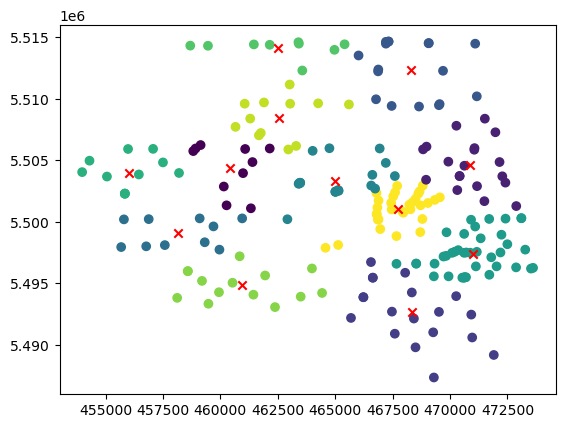

In [7]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

plot_clusters(gs_agg[['x', 'y']], labels, centers)

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

### Merge data

In [8]:
g_merged = merge_groundwater_data(g, gs_agg)
#g_merged.describe()

In [9]:
#g_merged.head()

In [10]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

# restrict data to the post-war period
m = m.loc[m.date > pd.to_datetime('1950-01-01')]

# drop all rows with a date after the weather data cutoff date
m = m.loc[m.date <= pd.to_datetime('2022-12-31')]

m = m.dropna(subset=['station_id_count'])

m['week_of_year'] = m['date'].dt.isocalendar().week

In [11]:
#m.info()

In [12]:
#m.describe()

## Train-test split

In [13]:
m.columns.unique()

Index(['station_id', 'date', 'water_dist', 'water_level', 'water_depth',
       'water_temp', 'x', 'y', 'start_date', 'end_date', 'ground_elev',
       'measure_elev', 'lifespan', 'geometry', 'water_level_mean',
       'water_depth_mean', 'water_temp_mean', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'reg_clusters', 'water_depth_anomaly',
       'station_id_count', 'precip_mean', 'precip_min', 'precip_max',
       'precip_std', 'tmean_mean', 'tmean_min', 'tmean_max', 'tmean_std',
       'tmax_mean', 'tmax_min', 'tmax_max', 'tmax_std', 'tmin_mean',
       'tmin_min', 'tmin_max', 'tmin_std', 'moisture_mean', 'moisture_min',
       'moisture_max', 'moisture_std', 'precip_mean_prev_2d_sum',
       'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'precip_mean_prev_1y_sum',
       'precip_mean_prev_3y_sum', 'tmean_mean_prev_2d_mean',
       'tmean_mean_prev_7d_mean'

In [14]:
# restrict data to these columns
df = m[['station_id',
        'date',
        'water_depth',
        'ground_elev',
        'x', 'y',
        'geometry',
        'reg_clusters',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_2d_sum',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'precip_mean_prev_1y_sum',
        'precip_mean_prev_3y_sum',
        'tmean_mean_prev_2d_mean',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean',
        'tmean_mean_prev_1y_mean',
        'tmean_mean_prev_3y_mean'
       ]]
#df.info()

In [15]:
#df[df.isna().any(axis=1)]

In [16]:
df = df.dropna()

In [17]:
train, test, X_train, X_test, y_train, y_test, info_train, info_test = tt_split_by_stations(df)


## Exploratory hyperparameter search

### Define preprocessing steps

In [18]:
# select categorical and numerical column names
#X_cat_columns = X_train.select_dtypes(exclude="number").columns
X_cat_columns = X_train.select_dtypes(include="int32").columns
X_num_columns = X_train.select_dtypes(include="float64").columns

# create numerical pipeline
num_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='mean')), # probably not needed...
           #('num_scaler', MinMaxScaler())
           ('num_scaler', StandardScaler())
          ])

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = Pipeline(
    steps=[#('cat_imputer', SimpleImputer(strategy='constant', fill_value='na')),
            #('cat_imputer', SimpleImputer(strategy='constant', fill_value=0)), 
           ('cat_encoder', OneHotEncoder(drop='first', 
                                         sparse_output=False, 
                                         handle_unknown='ignore'))
           #('cat_encoder', OrdinalEncoder())
          ])

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, X_num_columns), 
        ('cat', categoric_pipe, X_cat_columns)
    ],
    #remainder='passthrough'
).set_output(transform='pandas')

In [20]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  StandardScaler())]),
                                 Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_2d_sum', 'precip_mean_prev_...
       'precip_mean_prev_1y_sum', 'precip_mean_prev_3y_sum',
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['reg_clusters'], dtype='object'))])

### Define regressors to test

In [21]:
regressors = [
    #('SGD', SGDRegressor()),
    ('LinReg', LinearRegression()),
    ('HGBoost', HistGradientBoostingRegressor()), # excellent and very fast
]

### Create a pipeline for each regressor

In [22]:
pipelines = {}
for name, reg in regressors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('selector', SelectKBest(score_func=f_regression)),
        #('selector', RFECV(estimator=DecisionTreeRegressor())),
        #('feature_selection', SelectFromModel(DecisionTreeRegressor())),
        ('regressor', reg)
     ]).set_output(transform="pandas")
    pipelines[name] = pipeline


In [23]:
#pipelines['HGBoost']

### Define exploratory hyperparameters

In [24]:
param_grids_explore = {
    'SGD': {
        #'regressor__alpha': [0.00001, 0.001, 0.1], # d=0.0001
        'regressor__penalty': ['l1', 'l2', 'elasticnet'], # d='l2'
        #'regressor__learning_rate': ['optimal', 'invscaling' 'adaptive'], # d=invscaling
        #'regressor__max_iter': [100, 1000, 3000], # d=1000
        #'regressor__tol': [1e-3, 1e-4, 1e-5], # d=1e-3
        'regressor__loss': ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error'], # d=squared_error
        'regressor__early_stopping': [True, False], # d=False
        #'regressor__validation_fraction': [0.1, 0.2], # d=0.1
        'regressor__average': [True, False], # d=False
    },
    'LinReg': {
        # does not have tunable parameters
    },
    'HGBoost': {
        ##'regressor__learning_rate': [0.01, 0.1, 0.2], # d=0.1
        #'regressor__max_leaf_nodes': [5, 10, 30], # d=31
        #'regressor__max_depth': [None, 5, 10], # d=None
        #'regressor__min_samples_leaf': [5, 20, 50], # d=20
        #'regressor__l2_regularization': [0, 0.1], # d=0
        ##'regressor__max_bins': [255], # d=255
        ##'regressor__categorical_features': list(str('cat__' + X_cat_columns.values))
        #TODO: try to get categorical_features running...
    }
}


### Fit and evaluate models

In [ ]:
# Fit and evaluate each pipeline
scores_explore = {}
params_explore = {}
estimator_explore = {}
predictions = {}
metrics = {}
residuals = {}

fit_models = True # for turning off costly exploratory fitting

for name in pipelines:
    print(f"\nTraining and evaluating {name}...")
    pipe = pipelines[name]
    grid_search = GridSearchCV(pipe, 
                               param_grids_explore[name], 
                               cv=10, 
                               #scoring='neg_mean_absolute_error',
                               #scoring='neg_mean_squared_error',
                               #scoring='r2',
                               verbose=2, n_jobs=-1)
    
    if fit_models == True:
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        #y_pred = grid_search.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        
        print("Best parameters found:")
        print(grid_search.best_params_)
        #print("Classification report:")
        #print(classification_report(y_test, y_pred))
        #print(f"Accuracy: {accuracy:.4f}")
        
        scores_explore[name] = grid_search.best_score_
        params_explore[name] = grid_search.best_params_
        estimator_explore[name] = grid_search

        print('--- predict test data ---')
        y_pred = grid_search.predict(X_test)
        predictions[name] = y_pred
        metrics[name] = calc_metrics(y_test, y_pred)
        residuals[name] = calc_residuals(y_test, y_pred)


Training and evaluating LinReg...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters found:
{}
--- predict test data ---
MAE 0.6569707261943774
RMSE 0.9029527013640722
MAPE 241601787492.0683
R2 0.6841110165715978

Training and evaluating HGBoost...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [ ]:
scores_explore

In [ ]:
pd.DataFrame(params_explore)

In [ ]:
estimator_explore['LinReg']

In [ ]:
compare_models = pd.DataFrame(metrics)
compare_models

In [ ]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

In [ ]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

### Analyse models

In [ ]:
#model = 'LinReg'
model = 'HGBoost'
y_pred = predictions[model]
resid = residuals[model]

y_pred = pd.DataFrame(y_pred, columns=['pred_water_depth'])
y_pred.index = info_test.index
#y_pred

In [ ]:
test = pd.concat([info_test, X_test, y_test, y_pred, resid['residuals']],
                 axis='columns')

In [ ]:
#test.info()

In [ ]:
#test.describe()

In [ ]:
test.head()

In [ ]:
test.station_id.unique()[0]

In [ ]:
#data = train.loc[train.station_id == train.station_id.unique()[10]]
data = test.loc[test.station_id == test.station_id.unique()[10]]

plot_station_data(data#, pd.to_datetime('1958-01-01'), pd.to_datetime('1963-01-10')
                 #, pd.to_datetime('2010-01-01'), pd.to_datetime('2020-01-10')
                 )

## Refinement hyperparameter search

### Define refinement hyperparameters

In [ ]:
param_grids_refine = {
    'SGD': {
        #'regressor__alpha': [0.00001, 0.001, 0.1], # d=0.0001
        #'regressor__penalty': ['l1', 'l2', 'elasticnet'], # d='l2'
        #'regressor__learning_rate': ['optimal', 'invscaling' 'adaptive'], # d=invscaling
        #'regressor__max_iter': [100, 1000, 3000], # d=1000
        #'regressor__tol': [1e-3, 1e-4, 1e-5], # d=1e-3
        #'regressor__loss': ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error'], # d=squared_error
        #'regressor__early_stopping': [True, False], # d=False
        #'regressor__validation_fraction': [0.1, 0.2], # d=0.1
        #'regressor__average': [True, False], # d=False
    },
    'LinReg': {
        # does not have tunable parameters
    },
    'HGBoost': {
        ##'regressor__learning_rate': [0.01, 0.1, 0.2], # d=0.1
        #'regressor__max_leaf_nodes': [3, 5, 7], # d=31
        #'regressor__max_depth': [3, 5, 7], # d=None
        #'regressor__min_samples_leaf': [3, 5, 7], # d=20
        #'regressor__l2_regularization': [0, 0.05], # d=0
        ##'regressor__max_bins': [255], # d=255
        ##'regressor__categorical_features': list(str('cat__' + X_cat_columns.values))
        #TODO: try to get categorical_features running...
    }
}


### Fit and evaluate models

In [ ]:
# Fit and evaluate each pipeline
scores_refine = {}
params_refine = {}
estimator_refine = {}
predictions = {}
metrics = {}
residuals = {}

fit_models = True # for turning off costly exploratory fitting

for name in pipelines:
    print(f"\nTraining and evaluating {name}...")
    pipe = pipelines[name]
    grid_search = GridSearchCV(pipe, 
                               param_grids_refine[name], 
                               cv=10, 
                               #scoring='neg_mean_absolute_error',
                               #scoring='neg_mean_squared_error',
                               #scoring='r2',
                               verbose=2, n_jobs=-1)
    
    if fit_models == False:
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        #y_pred = grid_search.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        
        print("Best parameters found:")
        print(grid_search.best_params_)
        #print("Classification report:")
        #print(classification_report(y_test, y_pred))
        #print(f"Accuracy: {accuracy:.4f}")
        
        scores_refine[name] = grid_search.best_score_
        params_refine[name] = grid_search.best_params_
        estimator_refine[name] = grid_search

        print('--- predict test data ---')
        y_pred = grid_search.predict(X_test)
        predictions[name] = y_pred
        metrics[name] = calc_metrics(y_test, y_pred)
        residuals[name] = calc_residuals(y_test, y_pred)

In [ ]:
scores_refine

In [ ]:
pd.DataFrame(params_refine)

In [ ]:
estimator_refine['LinReg']

In [ ]:
compare_models = pd.DataFrame(metrics)
compare_models

In [ ]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

In [ ]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

### Analyse models

In [ ]:
#model = 'LinReg'
model = 'HGBoost'

y_train_pred = estimator_refine[model].predict(X_train)
train_resid = calc_residuals(y_train, y_train_pred)

y_test_pred = estimator_refine[model].predict(X_test)
test_resid = calc_residuals(y_test, y_test_pred)

y_train_pred = pd.DataFrame(y_train_pred, columns=['pred_water_depth'])
y_train_pred.index = info_train.index

y_test_pred = pd.DataFrame(y_test_pred, columns=['pred_water_depth'])
y_test_pred.index = info_test.index
#y_pred

In [ ]:
train = pd.concat([info_train, X_train, y_train, y_train_pred, train_resid['residuals']],
                 axis='columns')

test = pd.concat([info_test, X_test, y_test, y_test_pred, test_resid['residuals']],
                 axis='columns')

In [ ]:
#train.info()

In [ ]:
#test.info()

In [ ]:
#train.describe()

In [ ]:
#test.describe()

In [ ]:
#train.head()

In [ ]:
#test.head()

In [ ]:
train.station_id.unique()[0]

In [ ]:
test.station_id.unique()[0]

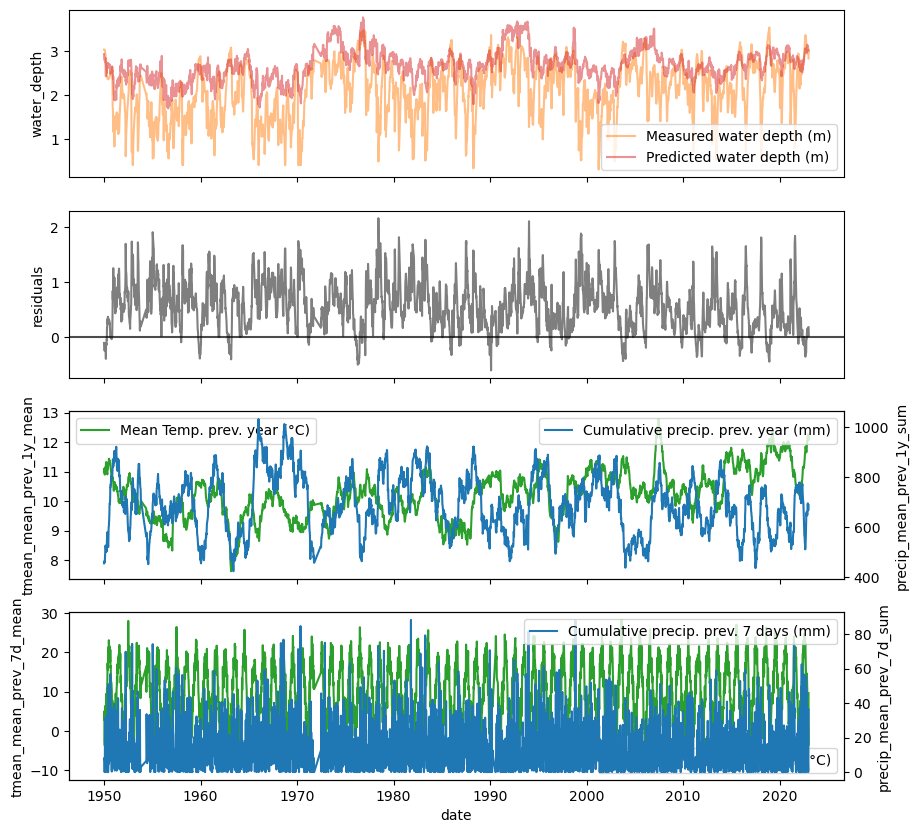

In [65]:
#data = train.loc[train.station_id == train.station_id.unique()[10]]
data = test.loc[test.station_id == test.station_id.unique()[2]]

plot_station_data(data)#, pd.to_datetime('1950-01-01'), pd.to_datetime('1970-01-10'))

## Pickle model

## Analyze station variability

In [66]:
#df = train.copy()
df = test.copy()
geos = df[['station_id', 'geometry']]

#df.columns.unique()
geos.head()

,station_id,geometry
date,,
1950-01-02,14082,POINT (8.46639 49.59807)
1950-01-02,14176,POINT (8.58855 49.59749)
1950-01-02,12902,POINT (8.45423 49.72066)
1950-01-02,12949,POINT (8.51111 49.70527)
1950-01-04,12911,POINT (8.48664 49.75174)


In [67]:
stats = df[['station_id', #'geometry',
    'water_depth', 'pred_water_depth',
    'residuals']].groupby('station_id'
                          ).agg({'water_depth': ['mean', 'std', 'min', 'max'],
                                 'pred_water_depth': ['mean', 'std', 'min', 'max'],
                                 'residuals': ['mean', 'std', 'min', 'max']})

stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
stats = pd.merge(left=stats, right=geos, on='station_id', how='left')
stats.head()

,station_id,water_depth_mean,water_depth_std,water_depth_min,water_depth_max,pred_water_depth_mean,pred_water_depth_std,pred_water_depth_min,pred_water_depth_max,residuals_mean,residuals_std,residuals_min,residuals_max,geometry
0,12892,3.590662,0.797871,-0.19,5.09,3.258301,0.557875,1.335206,4.6763,-0.33236,0.605326,-1.832045,2.814181,POINT (8.38953 49.70415)
1,12892,3.590662,0.797871,-0.19,5.09,3.258301,0.557875,1.335206,4.6763,-0.33236,0.605326,-1.832045,2.814181,POINT (8.38953 49.70415)
2,12892,3.590662,0.797871,-0.19,5.09,3.258301,0.557875,1.335206,4.6763,-0.33236,0.605326,-1.832045,2.814181,POINT (8.38953 49.70415)
3,12892,3.590662,0.797871,-0.19,5.09,3.258301,0.557875,1.335206,4.6763,-0.33236,0.605326,-1.832045,2.814181,POINT (8.38953 49.70415)
4,12892,3.590662,0.797871,-0.19,5.09,3.258301,0.557875,1.335206,4.6763,-0.33236,0.605326,-1.832045,2.814181,POINT (8.38953 49.70415)


In [68]:
stats = gpd.GeoDataFrame(stats, geometry=stats['geometry'], crs='EPSG:4326')

In [69]:
stats.sort_values(by='residuals_mean').head()

,station_id,water_depth_mean,water_depth_std,water_depth_min,water_depth_max,pred_water_depth_mean,pred_water_depth_std,pred_water_depth_min,pred_water_depth_max,residuals_mean,residuals_std,residuals_min,residuals_max,geometry
15486,12949,4.166626,1.299606,0.63,6.72,2.236383,0.49197,0.687443,3.67529,-1.930243,0.964751,-4.206012,1.073711,POINT (8.51111 49.70527)
15076,12949,4.166626,1.299606,0.63,6.72,2.236383,0.49197,0.687443,3.67529,-1.930243,0.964751,-4.206012,1.073711,POINT (8.51111 49.70527)
15075,12949,4.166626,1.299606,0.63,6.72,2.236383,0.49197,0.687443,3.67529,-1.930243,0.964751,-4.206012,1.073711,POINT (8.51111 49.70527)
15074,12949,4.166626,1.299606,0.63,6.72,2.236383,0.49197,0.687443,3.67529,-1.930243,0.964751,-4.206012,1.073711,POINT (8.51111 49.70527)
15073,12949,4.166626,1.299606,0.63,6.72,2.236383,0.49197,0.687443,3.67529,-1.930243,0.964751,-4.206012,1.073711,POINT (8.51111 49.70527)


In [70]:
# Load hillshade DEM
dem, dem_extent = load_dem('./data/dem/bergstraße30_shaded.tif')

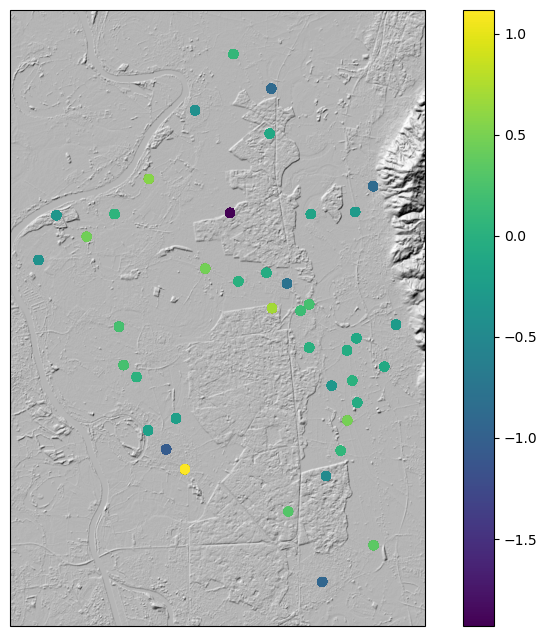

[CV] END .................................................... total time=  19.2s
[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=  50.2s
[CV] END .................................................... total time=  20.1s
[CV] END .................................................... total time=   8.8s
[CV] END .................................................... total time=  39.8s
[CV] END .................................................... total time=  20.2s
[CV] END .................................................... total time=  56.0s
[CV] END .................................................... total time=   8.4s
[CV] END .................................................... total time=  40.4s
[CV] END .................................................... total time=  20.1s
[CV] END .................................................... total time=  57.9s
[CV] END ...................

In [71]:
extent = stats.geometry.total_bounds

# Create a figure and axis with a PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()} # removes axis labels
                      )

# Plot hillshade DEM
ax.imshow(dem, extent=(dem_extent[0], dem_extent[2],
                       dem_extent[1], dem_extent[3]),
          cmap='gray', origin='upper', aspect='auto')

stats.plot(column='residuals_mean',
            #cmap='coolwarm',
            legend=True, 
            ax=ax)

ax.set_xlim(extent[0]-0.02, extent[2]+0.02)
ax.set_ylim(extent[1]-0.02, extent[3]+0.02)

#ax.legend(loc='lower left', framealpha=0.5)

#plt.title('Average water depth (m)')
#plt.savefig('./figs/map_mean_water_depth_all_stations.png', bbox_inches='tight')

# Show the plot
plt.show()

## Analyze Residuals over time

Must be resampled because station data begins on different dates.

In [108]:
test_weekly = test[['station_id',
                    'water_depth',
                    'pred_water_depth',
                    'residuals',
                    'tmean_mean_prev_1y_mean',
                    'precip_mean_prev_1y_sum']].groupby(by='station_id'
                                                       ).resample('W').mean()

In [109]:
test_weekly

station_id  water_depth  pred_water_depth  residuals  \
station_id date                                                               
12892      1951-11-04     12892.0         4.23          3.473885  -0.756115   
           1951-11-11     12892.0         4.25          3.379605  -0.870395   
           1951-11-18     12892.0         3.99          3.204736  -0.785264   
           1951-11-25     12892.0         3.75          3.243247  -0.506753   
           1951-12-02     12892.0         3.52          3.380299  -0.139701   
...                           ...          ...               ...        ...   
17129      2019-10-06         NaN          NaN               NaN        NaN   
           2019-10-13     17129.0         3.48          5.177571   1.697571   
           2019-10-20     17129.0         3.37          5.160824   1.790824   
           2019-10-27     17129.0         3.29          5.145384   1.855384   
           2019-11-03     17129.0         3.24          5.156069   1.916069   

                       tmean_mean_prev_1y_mean  precip_mean_prev_1y_sum  
station_id date                                                          
12892      1951-11-04                10.114901               723.584722  
           1951-11-11                10.167675               735.156944  
           1951-11-18                10.185651               721.341667  
           1951-11-25                10.223767               714.991667  
           1951-12-02                10.193097               687.647222  
...                                        ...                      ...  
17129      2019-10-06                      NaN                      NaN  
           2019-10-13                11.533699               613.675000  
           2019-10-20                11.504521               633.200000  
           2019-10-27                11.501370               660.275000  
           2019-11-03                11.550411               657.125000  

[97324 rows x 6 columns]

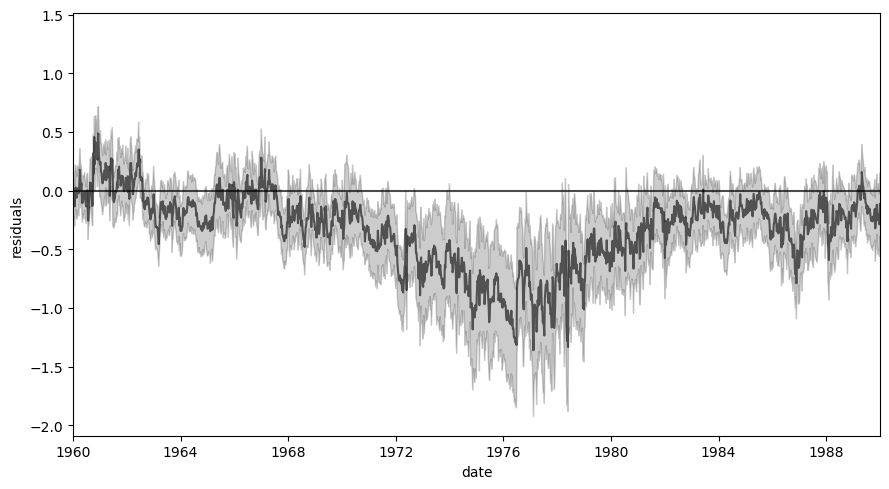

In [110]:
if True:
    fig, ax = plt.subplots(figsize=(9,5))
    sns.lineplot(data=test_weekly, x="date", y="residuals", 
                 errorbar='sd', color='black', alpha=0.6, ax=ax)
    ax.axhline(y=0, color='k', alpha=0.7)

    #plt.xlim(pd.to_datetime('1960-01-01'), pd.to_datetime('1990-01-01'))
    plt.tight_layout()
    plt.show()


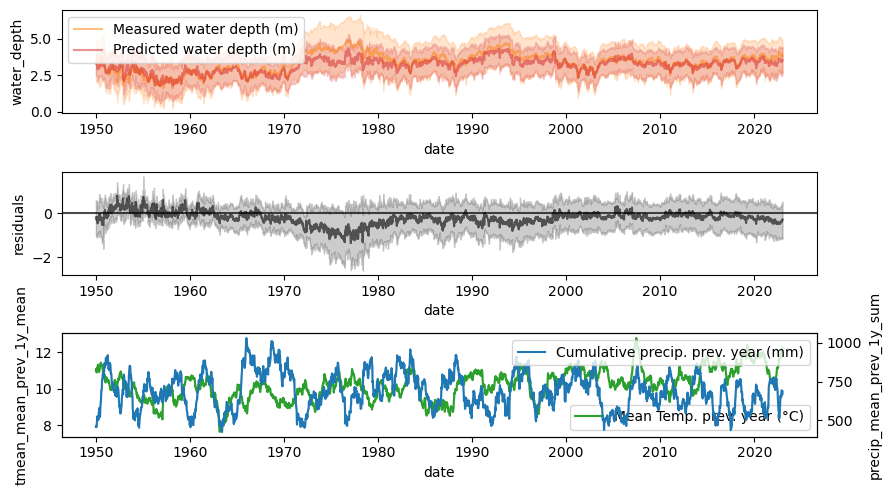

In [113]:
if False:
    fig, ax = plt.subplots(3, 1, figsize=(9,5))

    sns.lineplot(x="date", y="water_depth",
                 color='tab:orange', alpha=0.5, errorbar='sd',
                 data=test_weekly, ax=ax[0], label='Measured water depth (m)')
    
    sns.lineplot(x="date", y="pred_water_depth",
                 color='tab:red', alpha=0.5, errorbar='sd',
                 data=test_weekly, ax=ax[0], label='Predicted water depth (m)')
    #ax[0].set_xlim(start_date, end_date)

    
    sns.lineplot(data=test_weekly, x="date", y="residuals", 
                 errorbar='sd', color='black', alpha=0.6, ax=ax[1])
    ax[1].axhline(y=0, color='k', alpha=0.7)
    #ax[1].set_xlim(start_date, end_date)

    sns.lineplot(x="date", y="tmean_mean_prev_1y_mean", 
                     data=test_weekly, ax=ax[2], color='tab:green',
                     label='Mean Temp. prev. year (°C)')
    ax[2] = ax[2].twinx()
    sns.lineplot(x="date", y="precip_mean_prev_1y_sum", 
                 data=test_weekly, ax=ax[2], color='tab:blue',
                 label='Cumulative precip. prev. year (mm)')
    #ax[2].set_xlim(start_date, end_date)

    if False:
        for a in ax:
            start_date = pd.to_datetime('1960-01-01')
            end_date = pd.to_datetime('1990-01-01')
            a.set_xlim(start_date, end_date)

    #plt.xlim(start_date, end_date)
    plt.tight_layout()
    plt.show()


## TODO

- generalize hyperparameter exploration and model evaluation (especially for extremes)
- improve single station plotting routine

- implement location encoding by
    - discretizing x and y (pd.cut) and bucketing --> x-y grid
    - DONE performing clustering on the points with dbscan, kmean, knn, ...
- try to predict water_depth_anomaly?
- try with lag-shifted data...
- examine model accuracy (min/max/std of resids, ...) of each station
- maybe implement custom cv. the automatic one does not preserve station integrity. also using automatic cv=10 is enough.

## Lessons learned

hyperparameters

- HGBoost works well, but is still not fast enough for grid search while input data is not yet optimized. is better than linreg for extreme events.
- first use linreg until all is good